In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import json
import joblib
from PIL import Image

from tqdm import tqdm
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas.io.json import json_normalize
from sklearn import metrics
import chainer
from chainer import serializers, using_config
from chainer.dataset import to_device, concat_examples
import chainer.functions as F
import chainer.links as L
from chainer.iterators import MultiprocessIterator
from chainer.training import extensions
from chainercv.links.model.ssd import SSD512
from chainercv.visualizations import vis_semantic_segmentation,\
                                     vis_bbox

sys.path.append('../scripts')
from dataset import ImageSequenceDataset,\
                    ImageTextSequenceDataset,\
                    FitbDataset

/home/hiroshimatsui/.pyenv/versions/3.6.5/envs/bilstm-chainer/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


ModuleNotFoundError: No module named 'dataset'

In [154]:
mat_file = '../data/CFPD/fashon_parsing_data.mat'
f = h5py.File(mat_file, 'r')
list(f.keys())

['#refs#', 'all_category_name', 'all_colors_name', 'fashion_dataset']

In [155]:
len(f.get('#refs#'))

2719

In [156]:
# all category name
refs = f.get('all_category_name').value[0]
all_ctgs = []
for ref in refs:
    ctg = ''.join([chr(c) for c in f[ref].value])
    all_ctgs.append(ctg)
    
all_ctgs

#pd.Series(all_ctgs).to_csv('../data/CFPD/all_category_name.tsv',
#                           sep='\t')

['bk',
 'T-shirt',
 'bag',
 'belt',
 'blazer',
 'blouse',
 'coat',
 'dress',
 'face',
 'hair',
 'hat',
 'jeans',
 'legging',
 'pants',
 'scarf',
 'shoe',
 'shorts',
 'skin',
 'skirt',
 'socks',
 'stocking',
 'sunglass',
 'sweater']

In [157]:
def printkey(name, obj):
    print(name)

#f.visititems(printkey)

In [47]:
#cats = f.get('all_category_name')
#cats.shape
#type(cats.value[0][1])
#ref = cats.value[0][1]
#f[ref]
#f[ref].value

In [48]:
#n = 0
#for ref in cats.value[0]:
#    n_c = f[ref].shape[0]
#    f[ref].name, n_c, f[ref].value[:, 0]
#    n += n_c
#n

In [50]:
cats = f.get('all_colors_name')
cats.shape
ref = cats.value[0][0]
f[ref]
f[ref].value

(1, 13)

<HDF5 dataset "y": shape (2, 1), type "<u2">

array([[ 98],
       [107]], dtype=uint16)

In [51]:
#n = 0
#for ref in cats.value[0]:
#    n_c = f[ref].shape[0]
#    f[ref].name, n_c
#    n += n_c
#n

In [52]:
data = f.get('fashion_dataset')
ref = data[0][0]
f[ref]

<HDF5 group "/#refs#/L" (4 members)>

In [22]:
def print2(name, obj):
    print(name)
    
    t = type(obj)
    if t == h5py._hl.dataset.Dataset:
        print(t)
        print(obj.dtype)
        print(obj.shape)
        
    print()
        
f.get('#refs#/L').visititems(print2)

category_label
<class 'h5py._hl.dataset.Dataset'>
float64
(1, 425)

color_label
<class 'h5py._hl.dataset.Dataset'>
float64
(1, 425)

img_name
<class 'h5py._hl.dataset.Dataset'>
uint16
(9, 1)

segmentation
<class 'h5py._hl.dataset.Dataset'>
float32
(400, 600)



In [161]:
iter_ = iter(f.get('#refs#').values())

In [165]:
df = pd.DataFrame()
for outfit in tqdm(iter_, total=len(f.get('#refs#'))):
    try:
    #outfit = next(iter_)

        # super pix 2 category
        spix2ctg = outfit.get('category_label').value[0]
        #pd.Series(spix2ctg).value_counts().plot(kind='bar')

        # img_name
        ascii_codes = list(outfit.get('img_name'.format(i)).value[:,0])
        img_name = ''.join([chr(code) for code in ascii_codes ])


        # super pix
        spixseg = outfit.get('segmentation').value.T
        #plt.imshow(spixseg)

        # super pix -> semantic segmentation
        semseg = np.zeros(spixseg.shape)
        for i, c in enumerate(spix2ctg):
            semseg[spixseg == i] = c-1

        # semseg -> bbox
        bboxes = []
        labels = []
        for i, ctg in enumerate(all_ctgs):
            region = np.argwhere(semseg == i)
            if region.size != 0:
                bboxes.append(np.concatenate([region.min(0), region.max(0)]))
                labels.append(ctg)

        bboxes = np.array(bboxes).tolist()
        labels = np.array(labels).tolist()


        df = df.append({
            'img_name':img_name,
            'bboxes':bboxes,
            'categories':labels,
        }, ignore_index=True)
    except AttributeError:
        pass




  0%|          | 0/2719 [00:00<?, ?it/s]


  0%|          | 2/2719 [00:00<03:52, 11.71it/s]


  0%|          | 4/2719 [00:00<03:55, 11.53it/s]


  0%|          | 6/2719 [00:00<03:54, 11.58it/s]


  0%|          | 8/2719 [00:00<03:58, 11.38it/s]


  0%|          | 10/2719 [00:00<03:59, 11.33it/s]


  0%|          | 12/2719 [00:01<03:57, 11.39it/s]


  1%|          | 14/2719 [00:01<03:55, 11.47it/s]


  1%|          | 16/2719 [00:01<03:54, 11.52it/s]


  1%|          | 18/2719 [00:01<03:53, 11.56it/s]


  1%|          | 20/2719 [00:01<04:09, 10.80it/s]


  1%|          | 21/2719 [00:01<04:16, 10.52it/s]


  1%|          | 22/2719 [00:02<04:25, 10.17it/s]


  1%|          | 24/2719 [00:02<04:22, 10.28it/s]


  1%|          | 25/2719 [00:02<04:27, 10.06it/s]


  1%|          | 26/2719 [00:02<04:32,  9.88it/s]


  1%|          | 27/2719 [00:02<04:36,  9.73it/s]


  1%|          | 28/2719 [00:02<04:41,  9.58it/s]


  1%|          | 29/2719 [00:03<04:44,  9.45it/s]


  1%|          | 30/27

 15%|█▌        | 420/2719 [00:45<04:06,  9.33it/s]


 16%|█▌        | 422/2719 [00:45<04:06,  9.34it/s]


 16%|█▌        | 424/2719 [00:45<04:05,  9.35it/s]


 16%|█▌        | 426/2719 [00:45<04:05,  9.35it/s]


 16%|█▌        | 428/2719 [00:45<04:04,  9.36it/s]


 16%|█▌        | 430/2719 [00:45<04:04,  9.37it/s]


 16%|█▌        | 432/2719 [00:46<04:03,  9.38it/s]


 16%|█▌        | 434/2719 [00:46<04:03,  9.39it/s]


 16%|█▌        | 436/2719 [00:46<04:02,  9.40it/s]


 16%|█▌        | 438/2719 [00:46<04:02,  9.41it/s]


 16%|█▌        | 440/2719 [00:46<04:01,  9.42it/s]


 16%|█▋        | 442/2719 [00:46<04:01,  9.43it/s]


 16%|█▋        | 444/2719 [00:47<04:01,  9.44it/s]


 16%|█▋        | 446/2719 [00:47<04:00,  9.45it/s]


 16%|█▋        | 448/2719 [00:47<04:00,  9.45it/s]


 17%|█▋        | 450/2719 [00:47<03:59,  9.46it/s]


 17%|█▋        | 452/2719 [00:47<03:59,  9.47it/s]


 17%|█▋        | 454/2719 [00:47<03:58,  9.48it/s]


 17%|█▋        | 456/2719 [00:48<03:58,  9.49i

 32%|███▏      | 882/2719 [01:31<03:10,  9.62it/s]


 33%|███▎      | 884/2719 [01:31<03:10,  9.62it/s]


 33%|███▎      | 886/2719 [01:32<03:10,  9.63it/s]


 33%|███▎      | 888/2719 [01:32<03:10,  9.63it/s]


 33%|███▎      | 890/2719 [01:32<03:09,  9.63it/s]


 33%|███▎      | 892/2719 [01:32<03:09,  9.64it/s]


 33%|███▎      | 894/2719 [01:32<03:09,  9.64it/s]


 33%|███▎      | 896/2719 [01:32<03:08,  9.65it/s]


 33%|███▎      | 898/2719 [01:33<03:08,  9.65it/s]


 33%|███▎      | 900/2719 [01:33<03:08,  9.65it/s]


 33%|███▎      | 902/2719 [01:33<03:08,  9.65it/s]


 33%|███▎      | 904/2719 [01:33<03:08,  9.64it/s]


 33%|███▎      | 905/2719 [01:33<03:08,  9.64it/s]


 33%|███▎      | 906/2719 [01:34<03:08,  9.63it/s]


 33%|███▎      | 907/2719 [01:34<03:08,  9.63it/s]


 33%|███▎      | 908/2719 [01:34<03:08,  9.62it/s]


 33%|███▎      | 909/2719 [01:34<03:08,  9.62it/s]


 33%|███▎      | 910/2719 [01:34<03:08,  9.62it/s]


 34%|███▎      | 911/2719 [01:34<03:08,  9.61i

 48%|████▊     | 1306/2719 [02:16<02:27,  9.56it/s]


 48%|████▊     | 1307/2719 [02:16<02:27,  9.55it/s]


 48%|████▊     | 1308/2719 [02:16<02:27,  9.55it/s]


 48%|████▊     | 1309/2719 [02:17<02:27,  9.55it/s]


 48%|████▊     | 1311/2719 [02:17<02:27,  9.55it/s]


 48%|████▊     | 1312/2719 [02:17<02:27,  9.55it/s]


 48%|████▊     | 1313/2719 [02:17<02:27,  9.54it/s]


 48%|████▊     | 1314/2719 [02:17<02:27,  9.54it/s]


 48%|████▊     | 1315/2719 [02:17<02:27,  9.54it/s]


 48%|████▊     | 1316/2719 [02:18<02:27,  9.54it/s]


 48%|████▊     | 1317/2719 [02:18<02:27,  9.53it/s]


 48%|████▊     | 1318/2719 [02:18<02:27,  9.53it/s]


 49%|████▊     | 1319/2719 [02:18<02:26,  9.53it/s]


 49%|████▊     | 1321/2719 [02:18<02:26,  9.53it/s]


 49%|████▊     | 1323/2719 [02:18<02:26,  9.54it/s]


 49%|████▊     | 1325/2719 [02:18<02:26,  9.54it/s]


 49%|████▉     | 1327/2719 [02:19<02:26,  9.53it/s]


 49%|████▉     | 1328/2719 [02:19<02:25,  9.53it/s]


 49%|████▉     | 1329/2719 [

 61%|██████    | 1657/2719 [02:59<01:54,  9.24it/s]


 61%|██████    | 1658/2719 [02:59<01:54,  9.24it/s]


 61%|██████    | 1659/2719 [02:59<01:54,  9.23it/s]


 61%|██████    | 1660/2719 [02:59<01:54,  9.23it/s]


 61%|██████    | 1661/2719 [02:59<01:54,  9.23it/s]


 61%|██████    | 1662/2719 [03:00<01:54,  9.23it/s]


 61%|██████    | 1663/2719 [03:00<01:54,  9.23it/s]


 61%|██████    | 1664/2719 [03:00<01:54,  9.23it/s]


 61%|██████▏   | 1666/2719 [03:00<01:54,  9.23it/s]


 61%|██████▏   | 1668/2719 [03:00<01:53,  9.23it/s]


 61%|██████▏   | 1669/2719 [03:00<01:53,  9.23it/s]


 61%|██████▏   | 1670/2719 [03:01<01:53,  9.22it/s]


 61%|██████▏   | 1671/2719 [03:01<01:53,  9.22it/s]


 62%|██████▏   | 1673/2719 [03:01<01:53,  9.23it/s]


 62%|██████▏   | 1674/2719 [03:01<01:53,  9.23it/s]


 62%|██████▏   | 1675/2719 [03:01<01:53,  9.22it/s]


 62%|██████▏   | 1676/2719 [03:01<01:53,  9.22it/s]


 62%|██████▏   | 1677/2719 [03:01<01:53,  9.22it/s]


 62%|██████▏   | 1678/2719 [

 77%|███████▋  | 2105/2719 [03:43<01:05,  9.44it/s]


 77%|███████▋  | 2107/2719 [03:43<01:04,  9.44it/s]


 78%|███████▊  | 2109/2719 [03:43<01:04,  9.44it/s]


 78%|███████▊  | 2111/2719 [03:43<01:04,  9.44it/s]


 78%|███████▊  | 2114/2719 [03:43<01:04,  9.44it/s]


 78%|███████▊  | 2116/2719 [03:44<01:03,  9.45it/s]


 78%|███████▊  | 2118/2719 [03:44<01:03,  9.45it/s]


 78%|███████▊  | 2120/2719 [03:44<01:03,  9.45it/s]


 78%|███████▊  | 2122/2719 [03:44<01:03,  9.45it/s]


 78%|███████▊  | 2124/2719 [03:44<01:02,  9.45it/s]


 78%|███████▊  | 2126/2719 [03:44<01:02,  9.45it/s]


 78%|███████▊  | 2128/2719 [03:45<01:02,  9.45it/s]


 78%|███████▊  | 2130/2719 [03:45<01:02,  9.45it/s]


 78%|███████▊  | 2132/2719 [03:45<01:02,  9.45it/s]


 78%|███████▊  | 2134/2719 [03:45<01:01,  9.45it/s]


 79%|███████▊  | 2136/2719 [03:45<01:01,  9.46it/s]


 79%|███████▊  | 2138/2719 [03:46<01:01,  9.46it/s]


 79%|███████▊  | 2140/2719 [03:46<01:01,  9.46it/s]


 79%|███████▉  | 2142/2719 [

In [168]:
df = df[['img_name', 'bboxes', 'categories']]
df

,img_name,bboxes,categories
0,188274.jpg,"[[0, 0, 599, 399], [157, 186, 275, 275], [348,...","[bk, T-shirt, bag, coat, face, hair, hat, shoe..."
1,186066.jpg,"[[0, 0, 599, 399], [331, 208, 480, 307], [198,...","[bk, bag, belt, dress, face, hair, shoe, skin,..."
2,187484.jpg,"[[0, 0, 599, 399], [316, 141, 410, 184], [132,...","[bk, bag, blouse, face, hair, jeans, shoe, skin]"
3,185911.jpg,"[[0, 0, 599, 399], [223, 208, 335, 278], [202,...","[bk, bag, belt, dress, face, hair, shoe, skin]"
4,105231.jpg,"[[0, 0, 599, 399], [169, 92, 234, 181], [97, 1...","[bk, T-shirt, face, hair, shoe, skin, skirt, s..."
5,35780.jpg,"[[0, 0, 599, 399], [228, 114, 311, 176], [207,...","[bk, bag, belt, dress, face, hair, shoe, skin]"
6,179554.jpg,"[[0, 0, 599, 399], [57, 156, 278, 288], [0, 19...","[bk, blouse, face, hair, shoe, shorts, skin, s..."
7,10280.jpg,"[[0, 0, 599, 399], [164, 202, 213, 248], [291,...","[bk, T-shirt, bag, blouse, face, hair, legging..."
8,116718.jpg,"[[0, 0, 599, 399], [304, 110, 408, 163], [104,...","[bk, bag, dress, face, hair, shoe, skin]"
9,180624.jpg,"[[0, 0, 599, 399], [115, 165, 231, 279], [264,...","[bk, T-shirt, bag, face, hair, shoe, shorts, s..."


In [170]:
d = df.to_dict(orient='records')
with open('../data/CFPD/label/bbox.json', 'w') as f:
    json.dump(d, f, indent=4)

In [100]:
# load image
img = np.array(Image.open('../data/CFPD/image/{}'.format(img_name))\
               .convert('RGB'))
img = img.transpose(2,0,1)
img.shape

(3, 600, 400)

<Figure size 720x720 with 0 Axes>

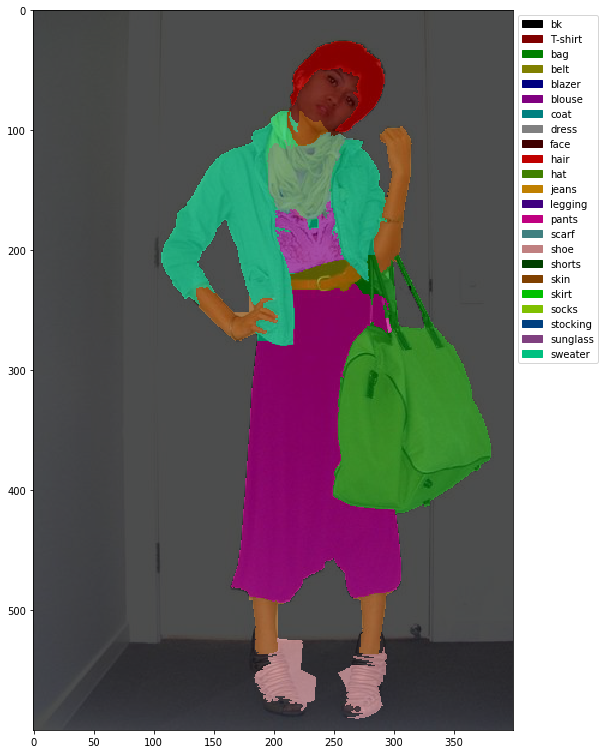

In [101]:
plt.figure(figsize=(10,10))
ax = plt.axes([0,0,1,1])
ax, legend_handles = vis_semantic_segmentation(
    img, semseg,
    label_names=all_ctgs,
    alpha=0.7,
    ax=ax
)
ax.legend(handles=legend_handles, bbox_to_anchor=(1,1), loc=2)
#plt.imshow(segmap, alpha=0.5)

In [127]:
main_ctgs = [
             'T-shirt',
             'blazer',
             'blouse',
             'coat',
             'dress',
             'jeans',
             'legging',
             'pants',
             'shoe',
             'shorts',
             'skirt',
             'stocking',
             'sweater'
            ]


#pd.Series(main_ctgs).to_csv('../data/CFPD/main_category_names.tsv',
#                           sep='\t')

def all2main(id_all):
    return main_ctgs.index(all_ctgs[id_all])

<Figure size 1440x720 with 0 Axes>

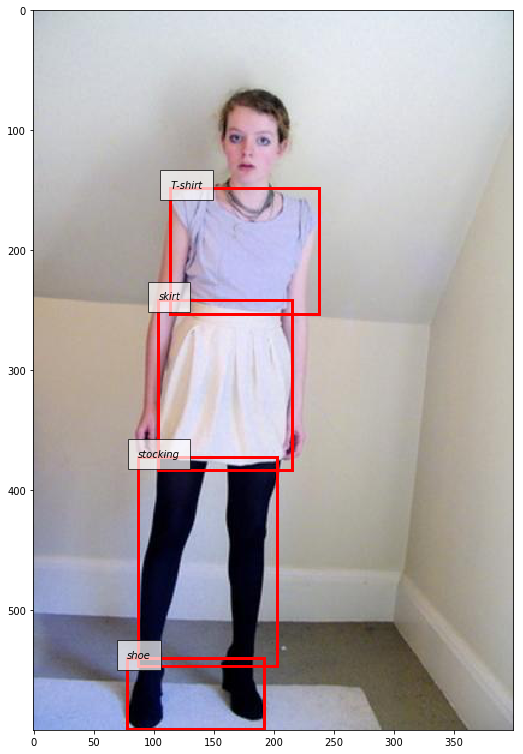

In [93]:
plt.figure(figsize=(20,10))
ax = plt.axes([0,0,1,1])
vis_bbox(img, bboxes, labels,
         label_names=main_ctgs,
         ax=ax)

In [171]:
j = json.load(open('../data/CFPD/label/bbox.json'))
frq = json_normalize(j, 'categories', ['img_name'])[0].value_counts()
frq

bk          2122
face        2119
hair        2106
skin        2099
shoe        2057
bag         1159
blouse       728
T-shirt      727
skirt        711
belt         632
dress        538
shorts       393
sunglass     334
blazer       277
coat         276
hat          270
stocking     227
sweater      200
legging      192
scarf        167
jeans        158
socks        140
pants        135
Name: 0, dtype: int64

In [172]:
from setup_cfpd_label import get_all_ctgs

mat_file = '../data/CFPD/fashon_parsing_data.mat'
f = h5py.File(mat_file, 'r')
all_ctgs = get_all_ctgs(f)
iter_ = iter(f.get('#refs#').values())
outfit = next(iter_)

In [177]:
# super pix 2 category
spix2ctg = outfit.get('category_label').value[0]
#pd.Series(spix2ctg).value_counts().plot(kind='bar')

# img_name
ascii_codes = list(outfit.get('img_name').value[:,0])
img_name = ''.join([chr(code) for code in ascii_codes ])

# super pix
spixseg = outfit.get('segmentation').value.T
#plt.imshow(spixseg)

# super pix -> semantic segmentation
semseg = np.zeros(spixseg.shape)
for i, c in enumerate(spix2ctg):
    semseg[spixseg == i] = c-1

# semseg -> bbox
bboxes = []
ctgs = []
for i, ctg in enumerate(all_ctgs):
    region = np.argwhere(semseg == i)
    if region.size != 0:
        bbox = {
            'ymin':int(region.min(0)[0]),
            'xmin':int(region.min(0)[1]),
            'ymax':int(region.max(0)[0]),
            'xmax':int(region.max(0)[1]),
        }
        bboxes.append(bbox)
        ctgs.append(ctg)

In [178]:
type(bboxes[0]['ymin'])

int

In [175]:
ctgs

['bk', 'coat', 'dress', 'face', 'hair', 'shoe', 'skin']